# Virtual Ecosystem with Boids

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import time
import random
import sys

from math import copysign # used to generate sign of integer (1 or -1)
from IPython.display import clear_output # allows jupyter to clear output using code

np.set_printoptions(linewidth=500)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

np.set_printoptions(threshold=sys.maxsize) # allows jupyter to show full numpy array

%matplotlib inline

## Essential Functions

In [2]:
# Function to create empty environment
def create_env(width, height):
    return np.zeros((width, height))

In [57]:
# Function to display environment frame by frame
# includes option to display frame counter to observe amount of time passed
# any text to be shown below frame must be passed into this function (this function is the last thing in the loop) 

def display_env_frame(env, delay, str_below=None, display_size = [7, 7]): # delay is the number of seconds previous frame stays visible
    # print frame counter
    try:
        global frame_num
        frame_num += 1
        print('Frame number: ', frame_num)
    except:
        pass
    
    # display frame
    fig, ax = plt.subplots(figsize=(display_size[0], display_size[1]))
    ax.set_axis_off()
    ax.matshow(env.T, origin='lower')
    plt.pause(0.001)
    
    # print string below if str_below is string
    if type(str_below) == str:
        print(str_below)
    
    # wait
    time.sleep(delay)
    
    return str_below


In [4]:
# Function to clear output (doesn't seem to work with Jupyter Notebook, might work with console)
from os import system, name 
  
# import sleep to show output for some time period 
from time import sleep 
  
# define our clear function 
def clear(): 
  
    # for windows 
    if name == 'nt': 
        _ = system('cls') 
  
    # for mac and linux(here, os.name is 'posix') 
    else: 
        _ = system('clear')

## Setting up Environment with Food

In [ ]:
# Visualize adding food randomly to environment
# food represented by 1 in env array

# variables
env_width = 40
env_height = 40
frame_delay = 0.5 # time between frames
num_food = 10
food_value = 1

# initilize environment
env = create_env(env_width, env_height)
# display initial state of env
display_env_frame(env, frame_delay)

# generate food in iterations and displays the food being added to env
while np.sum(env) / food_value < num_food:
    food_x_coor = random.randint(0, env_width - 1)
    food_y_coor = random.randint(0, env_height - 1)
    if env[food_x_coor][food_y_coor] == 0:
        env[food_x_coor][food_y_coor] = food_value
    else:
        continue
    display_env_frame(env, frame_delay)

In [18]:
# Function to add food to environment without displaying environment
def add_food(env, num_food, food_value=1):
    food_counter = 0
    while food_counter < num_food:
        food_x_coor = random.randint(0, env_width - 1)
        food_y_coor = random.randint(0, env_height - 1)
        if env[food_x_coor][food_y_coor] == 0:
            env[food_x_coor][food_y_coor] = food_value
            food_counter += 1
        else:
            continue
    return env

## Creating A Boid

In [79]:
# Animal: Boid
class SimpleBoid:
    
    def __init__(self, name_):
        self.name_ = name_ # set a name == var name
        self.location_ = [random.randint(0, env.shape[0] - 1), random.randint(0, env.shape[1] - 1)]
        self.energy_ = 100
        self.death_msg_ = str(self.name_) + ' has died!'
        # mark boid starting location in env
        env[self.location_[0], self.location_[1]] = 5
        
    def set_location(self, x_coor, y_coor):
        env[self.location_[0], self.location_[1]] = 0
        self.location_ = [x_coor, y_coor]
        env[self.location_[0], self.location_[1]] = 5
    
    # check if postion of boid exceeds env range and loops to the opposite side of env if boid is outside env
    def env_edge_loop(self, axis):
        # axis = 0 for x_axis, axis = 1 for y_axis
        
        # env limits
        max_env_coor = [env_width, env_height]
        
        # check if location of boid and loop if boid exceeds env limits
        if self.location_[axis] == max_env_coor[axis]:
            self.location_[axis] = 0
        elif self.location_[axis] == -1:
            self.location_[axis] = max_env_coor[axis] - 1
    
    
    # move 1 step in any direction (including diagonally), check edge, check food
    def simple_move(self, x_move, y_move):        
        # move boid
        self.location_[0] += int(x_move)
        self.location_[1] += int(y_move)
        # check if passed edge
        self.env_edge_loop(0)
        self.env_edge_loop(1)
        
        # food check
        if env[self.location_[0], self.location_[1]] == 1:
            self.eat()
            
            
    # move 1 step in any direction (including diagonally), edit env, update energy
    def move(self, x_move, y_move):
        # if boid is dead, dont move
        if self.name_ == 'dead':
            return
        
        # delete initial position of boid
        env[self.location_[0], self.location_[1]] = 0
        
        # energy cost when moving/not moving
        if x_move == 0 and y_move == 0:
            self.energy_change(-1)
        else:
            self.energy_change(-2)
        
        # move boid 1 step
        self.simple_move(x_move, y_move)
        
        # mark new position if not dead
        if self.name_ != 'dead':
            env[self.location_[0], self.location_[1]] += 5
        
        # if 2 boids end up at the same location, collide
        if env[self.location_[0], self.location_[1]] > 5:
            self.collide()
    
    
    def eat(self):
        env[self.location_[0], self.location_[1]] -= 1
        self.energy_ += 20
        
        
    def die(self):
        # delete boid from env
        env[self.location_[0], self.location_[1]] = 0
        # print death alert
        print(self.death_msg_)
        self.name_ = 'dead'
    
    
    def energy_change(self, energy_amount):
        self.energy_ += energy_amount
        # check if energy has run out, if no energy then boid dies 
        if self.energy_ <= 0:
            self.die()
    
    
    def display_energy(self):
        return str(self.name_) + ' has ' + str(self.energy_) + ' energy'
    
        
    # check status after every period before display
    def check_status(self):
        # if 2 boid stand on the same pixel, both boids will die
        if env[self.location_[0], self.location_[1]] > 5:
            self.die()

In [ ]:
# Movement checks

# reset env
env_width = env_height = 40
env = create_env(env_width, env_height)

x_coor = y_coor = range(-1, 2)
movement_coor = []
for x in x_coor:
    for y in y_coor:
        movement_coor.append([x, y])

# initialize boid
boid2 = SimpleBoid('boid2')
# set boid attr
boid2.energy_ = 1000
boid2.set_location(30, 30)
display_env_frame(env, 0.1)

for coor in movement_coor:
    for _ in range(5):
        boid2.move(coor[0], coor[1])
        display_above = 'Movement coor: ' + str(coor)
        display_env_frame(env, 0.6, str_above=display_above)
        if boid2.name_ == 'dead':
            break
    if boid2.name_ == 'dead':
        break

## Make a Boid Move Randomly in Environment with Food

In [53]:
# Define function for boid to move randomly in a similar pattern as 'move_random()'
# this functions makes the boid move 1 step
# previous path takes priority, if no path is available (num_steps = 0), then new path is generated

# path = [x_direction, y_direction, path_num_steps]

def move_random_path(boid, path, display=True, max_num_steps=5, delay=1):
    if path == None:
        return None
    
    if path[2] == 0:
        x_direction = random.randint(-1, 1)
        y_direction = random.randint(-1, 1)
        num_steps = random.randint(1 , max_num_steps)
        path = [x_direction, y_direction, num_steps]
        
    boid.move(path[0], path[1])
    if boid.name_ == 'dead':
        return None
    
    path[2] -= 1
    if display:
        display_above = 'Direction: ' + str([path[0], path[1]]) + '\nSteps Remaining: ' + str(path[2]) + '\nBoid Energy: ' + str(boid.energy_)
        print(display_above)
    
    return path

boid1 has died!
Frame number:  77


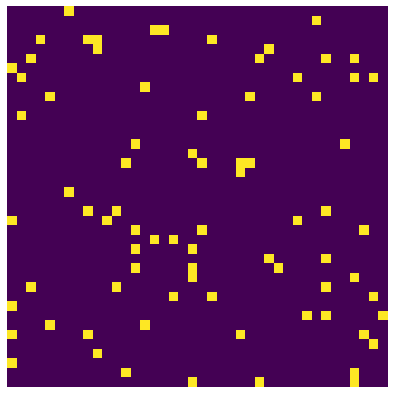

In [40]:
# variables
env_width = env_height = 40
frame_num = 0 # frame counter
frame_delay = 0.8
max_steps = 3 # max steps in any 1 direction
max_periods = 100 # max number of periods
num_food = 20
path = [0, 0, 0] # starting path (do not change)

# initialize env
env = create_env(env_width, env_height)

# add food
env = add_food(env, num_food)

# initialize boid
boid1 = SimpleBoid('boid1')

# display boid and food
print('Boid Energy: ' + str(boid1.energy_))
display_env_frame(env, 2)
clear_output(wait=True)

while frame_num < max_periods:
    
    if frame_num % 20 == 0:
        env = add_food(env, num_food)
    path = move_random_path(boid1, path)
    display_env_frame(env, frame_delay)
    if boid1.name_ == 'dead':
        break
    clear_output(wait=True)

## Multiple Boids Moving Randomly in Environment with Food

boid1
dead
Frame number:  147


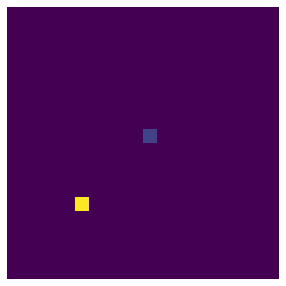

In [80]:
# Test collision
env = create_env(20, 20)
display_size = [5, 5]

boid1 = SimpleBoid('boid1')
boid2 = SimpleBoid('boid2')
boid3 = SimpleBoid('boid3')

boid1.set_location(10, 10)
boid2.set_location(10,14)
boid3.set_location(5, 5)

display_env_frame(env, 3, display_size=display_size)
clear_output(wait=True)

for _ in range(6):
    boid2.move(0, -1)
    print(boid1.name_)
    print(boid2.name_)
    display_env_frame(env, 1, display_size=display_size)
    clear_output(wait=True)



In [78]:
boid2.location_

[10, 8]

boid1 has died!
Frame number:  89


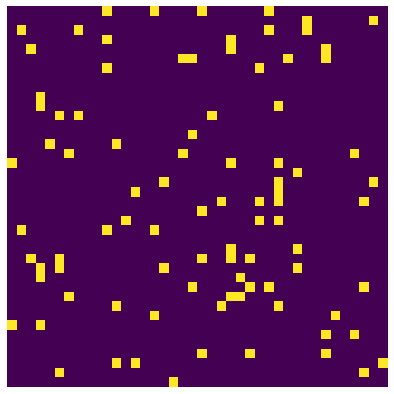

In [56]:
# variables
env_width = env_height = 40
frame_num = 0 # frame counter
frame_delay = 0.8
max_steps = 3 # max steps in any 1 direction
max_periods = 100 # max number of periods
num_food = 20
num_boids = 20
paths = [[0, 0, 0] for _ in range(num_boids)] # starting path (do not change)

# initialize env
env = create_env(env_width, env_height)

# add food
env = add_food(env, num_food)

# initialize boids
boids = [SimpleBoid('boid' + str(x)) for x in range(1, num_boids+1)]

# display boids and food
display_env_frame(env, 3)
clear_output(wait=True)

while frame_num < max_periods:
    
    if frame_num % 20 == 0:
        env = add_food(env, num_food)
    paths = [move_random_path(boids[x], paths[x], display=False) for x in range(num_boids)]
    display_env_frame(env, frame_delay)
    if all([path == None for path in paths]):
        break
    clear_output(wait=True)

In [60]:
env = create_env(20, 30)
env.shape

(20, 30)